In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import os

In [268]:
# df = pd.read_pickle("./aggregate_data.pkl")

In [269]:
def process_lbl(line_list, file): 
    name_dict = {}
    data_dict = {}
    name =''
    i = 0
    CSV = ["Filename,Application,Config,Is_Match,Testcase,Edges,States,Component,test,subtest,metric,metric_type"]
    while (i < len(line_list)):
        if i+1 < len(line_list) and line_list[i+1] == '---------,---------,---------,---------\n':
            firstTwoCols, edges, states = line_list[i].strip().rsplit(",", 2)
            name, regex = firstTwoCols.split(",", 1)
            i = i + 1
        elif line_list[i] == '---------,---------,---------,---------\n':
            i = i + 1
        elif line_list[i] != 'Component,test,subtest,metric,metric_type\n':
            CSV.append("{},{},{},{},{}".format(file,name,edges,states,line_list[i]))
            i = i + 1
        else:
            i = i + 1
    return pd.read_csv(StringIO("\n".join(CSV)))

In [270]:
# Filename -> "test, configuration, is_match?"
filemap = {
    "email_dkim": ["email", "Reef", True],
    "email_dkim_nwr.txt": ["email", "DFA+recursion", True],
    "email_dkim_hybrid": ["email", "SAFA+lookup", True],
    "email_dkim_naive.txt": ["email", "DFA", True],
    "pihole": ["odoh", "Reef", True],
    "pihole_hybrid": ["odoh", "SAFA+lookup", True],
    "pihole_nwr": ["odoh", "DFA+recursion", True],
    # "pihole_naive": ["oDoH", "DFA", True),
    "good_pass": ["password", "Reef", True],
    "bad_pass": ["password", "Reef", False],
    "good_pass_hybrid": ["password", "SAFA+lookup", True],
    "bad_pass_hybrid": ["password", "SAFA+lookup", False],
    "brca2_var1_match_proj": ["dna", "Reef", True],
    "brca2_primary_nonmatch_proj": ["dna", "Reef", False]
}

In [271]:
def parse_file(fn):
    if fn in filemap:
        with open(fn, 'r') as f:
            prefix = ','.join([fn] + [str(item) for item in filemap.get(fn)])
            return process_lbl(f.readlines(), prefix)
    else:
        pd.DataFrame()

In [272]:
df = pd.DataFrame()
for fn in os.listdir():
    df = pd.concat([df, parse_file(fn)], ignore_index=True)
        

In [273]:
df["test"].unique()

array(['Compiler', 'Verification', 'R1CS', 'SAFA', 'Proof', 'Prover',
       'prove', 'Solve', 'Witness Generation', 'add test', 'Proof Size',
       'DFA', 'Witness', 'Snark', 'DFA Solving', 'Verify', 'Prove',
       'Verifier'], dtype=object)

In [274]:
def canonical_test(x):
    xx = x.lower()
    
    d = { "prove" : "prover",
      "proof" : "prover",
      "add test": "prover",
      "compiler": "compiler",
      "verification": "verifier",
      "witness": "prover",
      "verifier": "verifier",
      "verify": "verifier",
      "solve": "solver",
      "solver": "solver",
      "dfa": "solver",
      "safa": "compiler",
      "snark": "prover",
      "dfa solving": "solver",
      "prover": "prover",
      "witness generation": "prover",
      "proof size": "prover" }
    return d.get(xx)


In [275]:
filemap

{'email_dkim': ['email', 'Reef', True],
 'email_dkim_nwr.txt': ['email', 'DFA+recursion', True],
 'email_dkim_hybrid': ['email', 'SAFA+lookup', True],
 'email_dkim_naive.txt': ['email', 'DFA', True],
 'pihole': ['odoh', 'Reef', True],
 'pihole_hybrid': ['odoh', 'SAFA+lookup', True],
 'pihole_nwr': ['odoh', 'DFA+recursion', True],
 'good_pass': ['password', 'Reef', True],
 'bad_pass': ['password', 'Reef', False],
 'good_pass_hybrid': ['password', 'SAFA+lookup', True],
 'bad_pass_hybrid': ['password', 'SAFA+lookup', False],
 'brca2_var1_match_proj': ['dna', 'Reef', True],
 'brca2_primary_nonmatch_proj': ['dna', 'Reef', False]}

In [315]:
compiler_q = df["Component"] == "compiler"
prover_q = df["Component"] == "prover"
verifier_q = df["Component"] == "verifier"

# subtest queries
full_q = df["subtest"] == "Full"

# Configuration querues
dfa_q = df["Config"] == "DFA"
nwr_q = (df["Config"] == "DFA+recursion")
safa_lookup_q = (df["Config"] == "SAFA+lookup")
reef_q = (df["Config"] == "Reef")

email_q = (df["Application"] == "email")
email_small_q = email_q & (df["States"] < 800)
email_large_q = email_q & (df["States"] == 908)
odoh_q = (df["Application"] == "odoh")

In [327]:
df[email_q & nwr_q]


,Filename,Application,Config,Is_Match,Testcase,Edges,States,Component,test,subtest,metric,metric_type
7923,email_dkim_nwr.txt,email,DFA+recursion,True,Message-ID_415,55424,433,solver,Witness,Compute_345,26467911,μs
7924,email_dkim_nwr.txt,email,DFA+recursion,True,Message-ID_415,55424,433,solver,Witness,Compute_190,26646913,μs
7925,email_dkim_nwr.txt,email,DFA+recursion,True,Message-ID_415,55424,433,prover,Prove,Prove_357,551621,μs
7926,email_dkim_nwr.txt,email,DFA+recursion,True,Message-ID_415,55424,433,solver,Witness,Compute_228,26754993,μs
7927,email_dkim_nwr.txt,email,DFA+recursion,True,Message-ID_415,55424,433,prover,Prove,Prove_291,615931,μs
...,...,...,...,...,...,...,...,...,...,...,...,...
8776,email_dkim_nwr.txt,email,DFA+recursion,True,Message-ID_1000,129664,1013,compiler,R1CS,Loading,170439,μs
8777,email_dkim_nwr.txt,email,DFA+recursion,True,Message-ID_1000,129664,1013,compiler,R1CS,Public Params,12543884,μs
8778,email_dkim_nwr.txt,email,DFA+recursion,True,Message-ID_1000,129664,1013,compiler,DFA,DFA,426983240,μs
8779,email_dkim_nwr.txt,email,DFA+recursion,True,Message-ID_1000,129664,1013,compiler,R1CS,Commitment Gen,48921,μs


In [323]:
dfe = df[email_q & full_q]
# Email graphs
dfe["size"] = df["States"].apply(lambda x: "small" if x < 800 else "large")
dfe["metric"] = df["metric"].apply(lambda x: float(x) / 10**6)
dfe.groupby(["Config", "size", "Component"])['metric'].max().reset_index()
dfe

/tmp/ipykernel_258323/3372131563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe["size"] = df["States"].apply(lambda x: "small" if x < 800 else "large")
/tmp/ipykernel_258323/3372131563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe["metric"] = df["metric"].apply(lambda x: float(x) / 10**6)


,Filename,Application,Config,Is_Match,Testcase,Edges,States,Component,test,subtest,metric,metric_type,size
9608,email_dkim_hybrid,email,SAFA+lookup,True,./tests/do_415,42315,331,verifier,Verification,Full,3.169613,μs,small
9617,email_dkim_hybrid,email,SAFA+lookup,True,./tests/do_415,42315,331,compiler,Compiler,Full,17.943699,μs,small
9625,email_dkim_hybrid,email,SAFA+lookup,True,./tests/do_415,42315,331,prover,Prover,Full,7.604506,μs,small
9626,email_dkim_hybrid,email,SAFA+lookup,True,./tests/do_415,42315,331,solver,Solve,Full,1.309517,μs,small
9632,email_dkim_hybrid,email,SAFA+lookup,True,./tests/do_1000,116748,908,solver,Solve,Full,5.750983,μs,large
9633,email_dkim_hybrid,email,SAFA+lookup,True,./tests/do_1000,116748,908,verifier,Verification,Full,3.282752,μs,large
9650,email_dkim_hybrid,email,SAFA+lookup,True,./tests/do_1000,116748,908,prover,Prover,Full,12.633310,μs,large
9652,email_dkim_hybrid,email,SAFA+lookup,True,./tests/do_1000,116748,908,compiler,Compiler,Full,105.005344,μs,large
9863,email_dkim,email,Reef,True,./tests/do_415,42315,331,prover,Prover,Full,8.570915,μs,small
9871,email_dkim,email,Reef,True,./tests/do_415,42315,331,verifier,Verification,Full,3.232376,μs,small


/tmp/ipykernel_258323/78821455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe["size"] = df["States"].apply(lambda x: "small" if x < 800 else "large")
/tmp/ipykernel_258323/78821455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe["metric"] = df["metric"].apply(lambda x: float(x) / 10**6)


,Config,size,metric
0,DFA,small,11000.660350
1,DFA+recursion,small,3435.310382
2,Reef,large,13.281955
3,Reef,small,18.742085
4,SAFA+lookup,large,12.633310
5,SAFA+lookup,small,17.943699


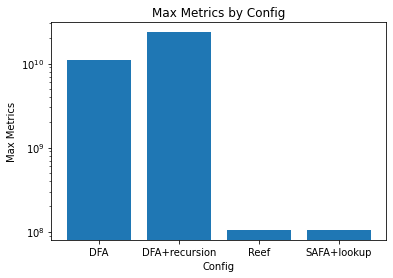

In [294]:
grouped = df.groupby('Config')['metric'].max().reset_index()

# Create a bar chart using Matplotlib
plt.bar(grouped['Config'], grouped['metric'])
# Group by 'config' and calculate the maximum 'metrics' value in each group
#grouped = df.groupby('config')['metric'].max().reset_index()

# Create a bar chart with a logarithmic y-axis scale
#plt.semilogy(grouped['Config'], grouped['metric'])
plt.yscale('log') 
plt.xlabel('Config')
plt.ylabel('Max Metrics')
plt.title('Max Metrics by Config')
plt.show()

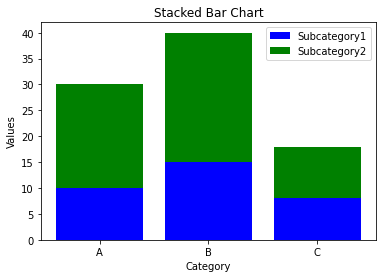

In [255]:
# Define the categories and subcategories
categories = df['Category']
subcategories = df.columns[1:]

# Create a list of colors for subcategories
colors = ['blue', 'green']

# Create a figure and axis
fig, ax = plt.subplots()

# Create a bar for each subcategory within each category
for i, subcategory in enumerate(subcategories):
    values = df[subcategory]
    bottom = df[subcategories[:i]].sum(axis=1) if i > 0 else 0
    ax.bar(categories, values, label=subcategory, bottom=bottom, color=colors[i])

# Add labels and legend
ax.set_xlabel('Category')
ax.set_ylabel('Values')
ax.set_title('Stacked Bar Chart')
ax.legend()

# Show the chart
plt.show()

In [256]:
df

,Category,Subcategory1,Subcategory2
0,A,10,20
1,B,15,25
2,C,8,10
